<center><font size="48"><h1>DTI Tutorial</h1></font></center>
<br>
# Matteo Visconti di Oleggio Castello 🇮🇹 <br>Manon de Villemejane 🇫🇷
### Day of GRR—Jun 2, 2017
### Dartmouth College


# What is Diffusion Weighted Imaging?

![](img/rokem_fig1.png)

Image from [Rokem et al., 2017](http://jov.arvojournals.org/article.aspx?articleid=2603187), released under CC-BY

From [Rokem et al., 2017](http://jov.arvojournals.org/article.aspx?articleid=2603187):

> Inferences about white matter from measurements of water diffusion. <br>
(A) Micrograph of the human optic nerve. Left, bundles of myelinated axonal fascicles from the human optic nerve (image courtesy of Dr. George Bartzokis). Right, cartoon example of anisotropic water diffusion restriction by white matter fascicles. Water diffuses further along the direction of the “tube” (Pierpaoli & Basser, 1996). <br>
(B) Example of diffusion-weighted magnetic resonance measurements in a single slice of a living human brain. The same brain slice is shown as imaged with two different diffusion weighting directions. Diffusion weighting directions are shown by the inset arrows. The white highlighted area indicates the approximate location of part of the optic radiation (OR). The longitudinal shape of the OR appears as a local darkening of the MRI image when the diffusion-weighting gradient is aligned with the direction of the myelinated fascicles within the OR (right-hand panel).

![](img/rokem_fig3.png)
Image from [Rokem et al., 2017](http://jov.arvojournals.org/article.aspx?articleid=2603187), released under CC-BY

From [Rokem et al., 2017](http://jov.arvojournals.org/article.aspx?articleid=2603187):

> Relationship between dMRI signals, voxel models of diffusion, and tractography. <br>
(A) An axial brain slice. Two voxel locations are indicated in blue and green. The white rectangle indicates the location of the images in panel C. <br>
(B) Measured diffusion-weighted MRI in the colored locations in panel A. Left column: Diffusion signal for the green (top) and blue (bottom) locations rendered as 3-D surfaces with the color map indicating the intensity of the diffusion-weighted signal in each direction (red is low signal or high diffusion and yellow-white is high signal or low diffusion). Middle column: The 3-D Gaussian distribution of diffusion distance, estimated from the DTM for the signal to the left. The major axis of the ellipsoid indicates the PDD estimated by the tensor model, different for the two voxels. Right column: fODF estimated by a fascicle mixture model: The constrained spherical deconvolution (CSD) model (Tournier et al., 2007) from the signal to its left. CSD indicates several probable directions of fascicles. Color map indicates likelihood of the presence of fascicles in a direction. <br>
(C) Top panel: Detail of the region highlighted in panel A (white frame) with example of two seeds randomly placed within the white matter and used to generate the fascicles in the bottom panel. Bottom panel: Fits of the CSD model to each voxel and two example tracks (streamlines) crossing at the location of the centrum semiovale.

# Time to play with some data
- I will put the notebook and slides up: don't worry about the code!
- It's more important to understand the steps.
- Huge thanks to Rachel and Jessi for sharing their data with me!

# Caveat 
- This is an exploration: we don't know yet if this is the **optimal** way to analyze DWI data (most likely it's not)
- It's been very useful for us to understand the data better

# Source
- Most of the code here comes from [dipy](http://nipy.org/dipy/)'s tutorials
![](img/dipy-logo.png)


In order to share the notebook, we're going to use some publicly available dataset. In particular, I'm going to use the dataset `ds000030` from the [OpenfMRI](https://openfmri.org/dataset/ds000030/) repository. We will download one subject's anatomical and DWI data using [DataLad](http://datalad.org/).

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
import datalad.api as dl
from IPython.display import Image

First, we're going to install the dataset under `./data` using datalad. We're not downloading any large files yet, only checking out the structure of the directory

In [2]:
ds = dl.install(path='./data', source='////openfmri/ds000030')

[INFO] <Dataset path=/Users/contematto/github/grr_dti_tutorial/data> was already installed from http://datasets.datalad.org//openfmri/ds000030/.git. Use `update` to obtain latest updates, or `get` or `install` with a path, not URL, to (re)fetch data and / or subdatasets 


Let's see what we got

In [3]:
!ls ./data/ | head

CHANGES
README
dataset_description.json
derivatives
participants.tsv
phenotype
sub-10159
sub-10171
sub-10189
sub-10193


Now we're ready to download some data

In [4]:
from glob import glob

In [5]:
ds.get(glob(ds.path + '/sub-10159/dwi/*'))
ds.get(glob(ds.path + '/sub-10159/anat/*'))

[INFO] Getting 4 items of dataset <Dataset path=/Users/contematto/github/grr_dti_tutorial/data> ... 
[INFO] Getting 2 items of dataset <Dataset path=/Users/contematto/github/grr_dti_tutorial/data> ... 


[]

In [6]:
!ls ./data/sub-10159/{anat,dwi}/

./data/sub-10159/anat/:
sub-10159_T1w.json   sub-10159_T1w.nii.gz

./data/sub-10159/dwi/:
sub-10159_dwi.bval   sub-10159_dwi.json
sub-10159_dwi.bvec   sub-10159_dwi.nii.gz


Once we converted the DICOMs to NIFTI in BIDS format, under the `dwi` directory we'll have four filetypes:

1. \*.nii.gz: nifti files with acquired data
2. \*.bval: *b* values
3. \*.bvec: vectors associated to *b* values
4. \*.json: file containing information on acquisition sequence

In [7]:
# set up filenames
dwi_fn = './data/sub-10159/dwi/sub-10159_dwi.nii.gz'
bval_fn = dwi_fn.replace('nii.gz', 'bval')
bvec_fn = dwi_fn.replace('nii.gz', 'bvec')

# load image
dwi = nib.load(dwi_fn)
# get data and header
dwi_d = dwi.get_data()
dwi_h = dwi.header
dwi_affine = dwi.affine

In [8]:
# shape of our 4D tensor
print(dwi_d.shape)
# voxel size
print(dwi_h.get_zooms()[:-1])

(96, 96, 50, 65)
(1.9791666, 1.9791666, 2.0)


- The DWI data a 4D tensor (similar to fMRI)
- The 4th dimension represents the direction of the gradient (same index as the bvec file) with the respective b-value (same index as the bval file)

In [9]:
# load bvals and bvecs using dipy's tools
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(bval_fn, bvec_fn)

from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [10]:
print(bvals[:10, None])

[[    0.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]
 [ 1000.]]


In [11]:
print(bvecs[:10])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -9.99984000e-01   4.03613000e-03   4.03613000e-03]
 [ -9.92980000e-04  -9.99987000e-01   4.98886000e-03]
 [ -2.48897000e-02   6.53243000e-01  -7.56739000e-01]
 [ -5.89518000e-01   7.69236000e-01   2.46462000e-01]
 [  2.35626000e-01   5.28739000e-01   8.15423000e-01]
 [  8.93067000e-01   2.63666000e-01   3.64570000e-01]
 [  7.97398000e-01   1.33552000e-01  -5.88489000e-01]
 [  2.32919000e-01   9.31812000e-01  -2.78344000e-01]
 [  9.36380000e-01   1.44036000e-01  -3.20072000e-01]]


In [12]:
print(len(bvals), len(bvecs))

(65, 65)


This sequence had 64 directions with constant $b$-value: 1000

We can visualize the direction of the gradients plotting the `bvecs`

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


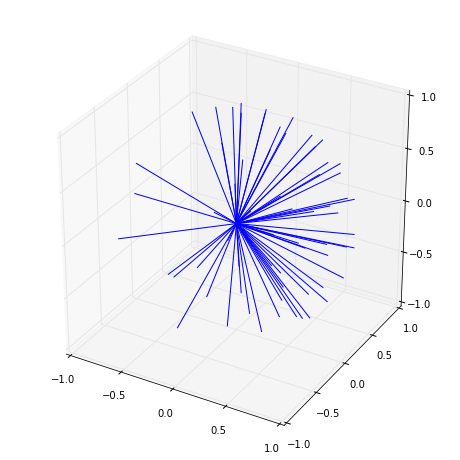

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for x, y, z in bvecs:
    ax.plot_wireframe([0, x], [0, y], [0, z])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1);

OK, now we can start analyzing our data. First, let's see what it looks like.

In [14]:
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq

In [15]:
# just a handy function to plot
def plot_axial(img, where=35, ax=None, mask=None):
    if ax is None:
        plotter = plt
    else:
        plotter = ax
    img_ = img.copy()
    if mask is not None:
        img_[np.logical_not(mask)] = 0.
    plotter.imshow(histeq(img_[:, :, where].T), origin='lower', 
                   cmap='gray', interpolation='nearest')

# First volume, with $b = 0$, i.e. no diffusion weight

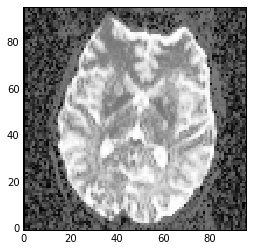

In [16]:
plot_axial(dwi_d[:, :, :, 0], where=10)

# The plan

1. Preprocessing
    - Reslicing
    - Skull stripping
2. Tractography
    - Fit tensor model
    - Discover tracts
3. Visualize

# Reslicing

- Many of the methods for tractography require isotropic voxels
- I'm not sure about this, but I would think it's better to have isotropic voxels out of the scanner, since we have less reslicing
- However, we can reslice easily in dipy.

In [17]:
print("Voxel size is {0}".format(dwi.header.get_zooms()[:3]))

Voxel size is (1.9791666, 1.9791666, 2.0)


In [18]:
from dipy.align.reslice import reslice
new_zooms = (2., 2., 2.)
dwi_d2, dwi_affine2 = reslice(dwi_d, dwi_affine, dwi.header.get_zooms()[:3], new_zooms)
print(dwi_d.shape, dwi_d2.shape)

/Users/contematto/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


((96, 96, 50, 65), (95, 95, 50, 65))


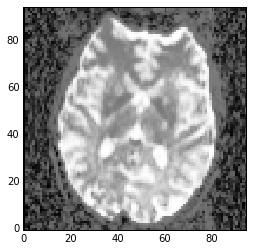

In [19]:
plot_axial(dwi_d2[:, :, :, 0], 10)

# Skull stripping

- We can use many fancy methods (FSL's `BET`, AFNI's `3dSkullStrip`, FreeSurfer...)
- Instead, we'll use a super quick way of separating an image from the background, the so-called **Otsu's method**.<br>You can read more about it on [Wikipedia](https://en.wikipedia.org/wiki/Otsu%27s_method) if you are interested.
- We are going to perform skull-stripping on the image with $b = 0$, because it has better contrast

In [20]:
# select the b0 data
data_b0 = dwi_d2[:, :, :, 0].squeeze()
# N.B. this values (2, 1, dilate=2) are completely ad-hoc. 
# do not use this for your research unless you know what you're doing.
b0_mask, mask = median_otsu(data_b0, 2, 1, dilate=2)

Let's see what we got

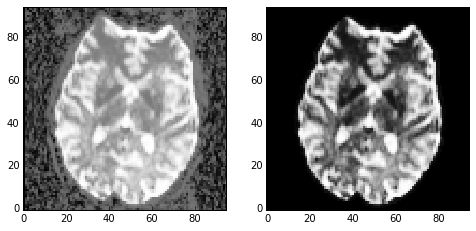

In [21]:
fig, axs = plt.subplots(1, 2, figsize=((8, 6)))
for i, ax in enumerate(axs.flatten()):
    mask_ = None if i == 0 else mask
    plot_axial(data_b0, ax=ax, mask=mask_, where=10)

# Motion correction and eddy distortions (skipped)

- At this point you should perform some sort of alignment to correct for motion
- You should correct for "eddy distortions", i.e. distortions caused by the rapid change in gradient

This example comes from FSL's wiki showing how `eddy` corrects distortions, see their page: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy

In [22]:
from IPython.display import Image, display, HTML
Image(url='https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy?action=AttachFile&do=get&target=before_after_hcp_v4.gif', width=600)

How about in this dataset?

In [24]:
# save individual slices
import subprocess as sp
import os
if not os.path.exists('img/dwi.gif'):
    try:
        os.makedirs('./img_out')
    except OSError:
        pass
    for i in range(1, dwi_d2.shape[-1]):
        fig, ax = plt.subplots(1, 1)
        plot_axial(dwi_d2[:, :, :, i], ax=ax, where=10)
        fig.savefig('img_out/dwi{0:02d}.png'.format(i))
        plt.close()
        
    _ = sp.check_call("convert img_out/dwi*.png -trim -delay 10 img/dwi.gif".split())

# This DWI data

<img src='img/dwi.gif'>

We do see a lot of distortions and especially a lot of movement during the scan. For a real analysis, you would make sure to perform some motion correction and re-alignment, as well as eddy correction.

- BUT we don't have time, so we are going to skip it altogether. 
- It's also possible to perform some denoising, but for time constraints we are going to skip that too. Read more about it on the dipy tutorial [Denoise images using Non-Local Means (NLMEANS)](http://nipy.org/dipy/examples_built/denoise_nlmeans.html#example-denoise-nlmeans)

It's time to run our model and get some tracts.

# Tractography

- In the end, we want to estimate white-matter tracts, with some nice pictures. To get there, we need two things:
    1. Model the diffusion data per-voxel basis (think GLM), to get the most likely direction
    2. Find the tracts
<br>
- For step 1 we are going to use the **Tensor Model**, but there are many other models
- For step 2 we are going to use **deterministic tractography**

# Tensor Model
This part is heavily based on the dipy tutorial [Reconstruction of the diffusion signal with the Tensor model](http://nipy.org/dipy/examples_built/reconst_dti.html#example-reconst-dti)

So, what is this "Tensor Model"?

For each voxel, we are modeling the diffusion signal as follows:

$$\frac{S(\mathbf{g},b)}{S_0} = e^{-b\mathbf{g}^T\mathbf{D}\mathbf{g}}$$

with our particular dataset, we will always have $b = 1,000$, and $\mathbf{g}$ is just the rows we have in the bvec files, indicating the direction of the gradient.<br>See why we need bvals and bvecs?

In the end, we want to discover $\mathbf{D}$, which is a matrix indicating the *diffusivity* along the three axis, with 6 free parameters to be estimated:

$$   \mathbf{D} = \begin{pmatrix} D_{xx} & D_{xy} & D_{xz} \\
                       D_{yx} & D_{yy} & D_{yz} \\
                       D_{zx} & D_{zy} & D_{zz} \\ \end{pmatrix}$$
                       
It's 6 parameters because we assume that $D_{xy} = D_{yx}$.

Enough math! Let's fit it.

In [25]:
import dipy.reconst.dti as dti

# set up tensor model giving the bval/bvec information
tenmodel = dti.TensorModel(gtab)

# get masked data
dwi_d2_masked = dwi_d2.copy()
dwi_d2_masked[np.logical_not(mask)] = 0.

# fit tensor model to masked data
tenfit = tenmodel.fit(dwi_d2_masked)

Done!

Now we can estimate the *Fractional Anisotropy*, an index of how directional each voxel is.

Meaning:

![Fractional Anistropy](img/FA.png)

with $\lambda_i$ eigenvalues of $\mathbf{D}$

image from https://openi.nlm.nih.gov/detailedresult.php?img=PMC3194768_kjr-12-651-g001&req=4

In [26]:
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular
FA = fractional_anisotropy(tenfit.evals)
# set nans to 0 (e.g., when there is not enough signal)
FA[np.isnan(FA)] = 0

Let's check what we got

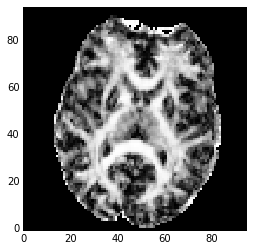

In [27]:
plot_axial(FA, where=10)


Let's try to make something fancier...

In [28]:
# Get RGB colors indicating the direction from the eigen vectors
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
ren = fvtk.ren()
# zoom in into a nice area
evals = tenfit.evals[20:70, 10:50, 10:11]
evecs = tenfit.evecs[20:70, 10:50, 10:11]

cfa = RGB[20:70, 10:50, 10:11]
cfa /= cfa.max()

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))
fvtk.record(ren, n_frames=1, out_path='img/tensor_ellipsoids.png', size=(800, 800))

This is where we zoomed in:

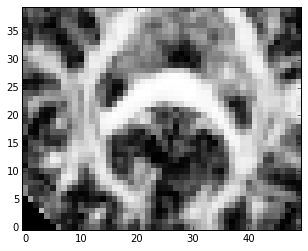

In [29]:
plot_axial(FA[20:70, 10:50, :], where=11)

And this is what we get:

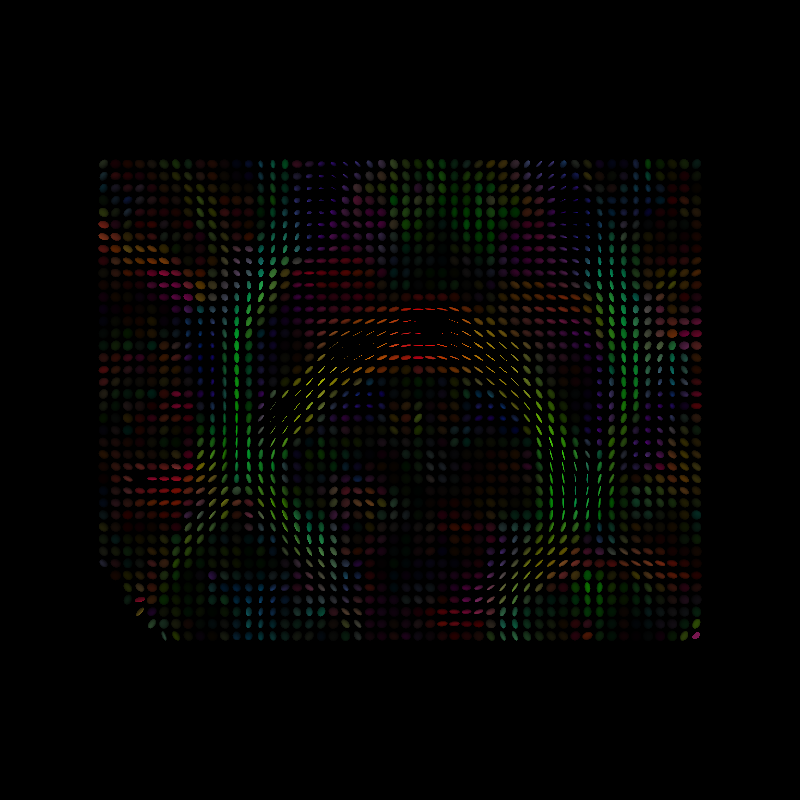

In [30]:
Image('img/tensor_ellipsoids.png')

# Tractography

Before starting, it's a good idea to have a white-matter mask, so that we use only on white-matter voxels. 

We don't have time to go over the entire process, but this is what I did (you can see the alignment step in the notebook when you download it):

1. FSL's `BET` to remove the skull
2. FSL's `FAST` to segment white and gray matter
3. dipy to align the brain to the DWI b0, and use the affine to align the white-matter mask to the DWI

I performed steps 1. and 2. already, and I'm providing the white-matter mask with this notebook. That is `wm-mask/sub-10159_T1w_brain_seg_2.nii.gz`

In [31]:
!ls -lh wm-mask/sub-10159_T1w_brain_seg_2.nii.gz

-rw-r--r--  1 contematto  staff   201K Jun  3 18:40 wm-mask/sub-10159_T1w_brain_seg_2.nii.gz


Now we're ready to align the anatomical to the DWI, so that we can obtain an affine transformation to align the white matter mask as well to the DWI, and take only white-matter voxels.

In [32]:
# The code for the alignment comes from dipy's tutorial
# http://nipy.org/dipy/examples_built/affine_registration_3d.html
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

# We want to align the anatomical to the DWI b0, so we can align also the mask
# let's take the skull-stripped one
static = np.squeeze(dwi_d2_masked[:, :, :, 0])
static_grid2world = dwi_affine2
# and now let's take the skull-stripped anatomical
anat = nib.load('wm-mask/sub-10159_T1w_brain.nii.gz')
moving = anat.get_data()
moving_grid2world = anat.affine

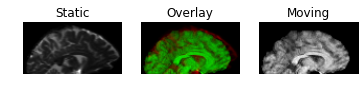

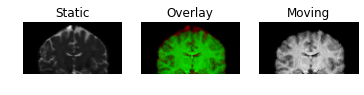

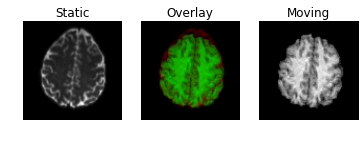

In [33]:
# no transformation applied, let's see where we're starting from
identity = np.eye(4)
affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving");
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving");
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving");

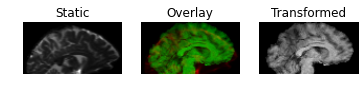

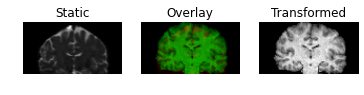

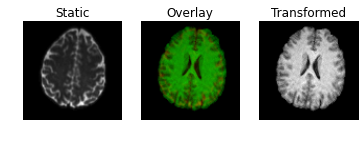

In [34]:
# move only center of mass of the two images
c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)

transformed = c_of_mass.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed");

In [35]:
# use a fancier method using Mutual Information
# see http://nipy.org/dipy/examples_built/affine_registration_3d.html
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

# set up pyramids
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

# set up affine registration
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [36]:
# first use only translation
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


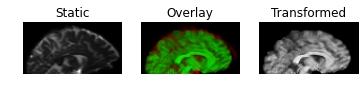

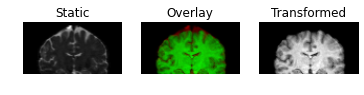

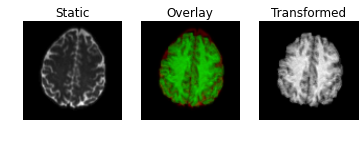

In [37]:
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed");

In [38]:
# then allow also rotations, using the previous affine
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


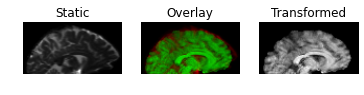

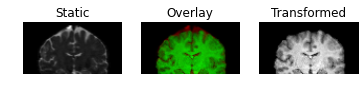

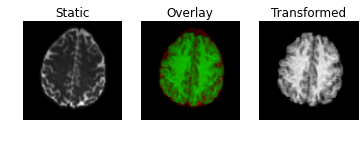

In [39]:
transformed = rigid.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed");

In [40]:
# finally allow also shear
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


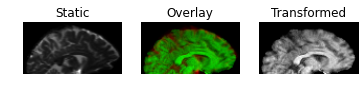

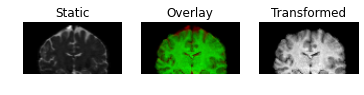

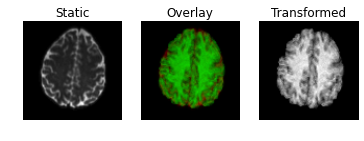

In [41]:
transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed");
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed");

In [42]:
# now we can apply the transformation to the white matter mask
white_matter = nib.load('wm-mask/sub-10159_T1w_brain_seg_2.nii.gz')
white_matter_data = white_matter.get_data()
white_matter_transformed = affine.transform(white_matter_data, interp='nearest')

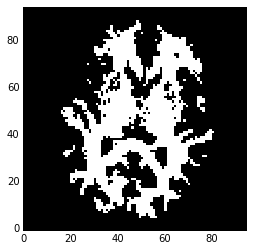

In [43]:
plot_axial(white_matter_transformed, where=10)

# Reconstructing Tracts

In [44]:
from dipy.tracking import utils
from dipy.tracking.local import ThresholdTissueClassifier, LocalTracking
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.tracking.local import LocalTracking
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors
from dipy.tracking.streamline import select_random_set_of_streamlines
from dipy.io.trackvis import save_trk

In [45]:
# find out peaks from our model
peaks = peaks_from_model(tenmodel, dwi_d2, default_sphere,
                 relative_peak_threshold=.8,
                 min_separation_angle=45,
                 mask=white_matter_transformed, 
                 parallel=True, nbr_processes=4)

In [47]:
# first we need to set the seeds. we'll just have one seed for each voxel.
# if you increase that, you will get more tracts
seeds = utils.seeds_from_mask(white_matter_transformed, density=1, affine=dwi_affine2)

In [48]:
# then we build a "tissue classifier" to know when to stop with our tracts white from gray matter
# it's very simple: whatever has an FA value greater than a threshold is considered white-matter
classifier = ThresholdTissueClassifier(FA, .25)

# next we build the streamlines
streamlines = LocalTracking(peaks, classifier, seeds, dwi_affine2, step_size=.5)

# streamlines is a generator, so we get a list to compute all of them
streamlines = list(streamlines)
# we select a random subset for visualization
plot_streamlines = select_random_set_of_streamlines(streamlines, 10000)

In [49]:
# Prepare the display objects.
streamlines_actor = fvtk.line(plot_streamlines, line_colors(plot_streamlines))

# Create the 3d display.
r = fvtk.ren()
fvtk.add(r, streamlines_actor)

# Save still images for this static example. Or for interactivity use
fvtk.record(r, n_frames=1, out_path='img/deterministic.png',
            size=(800, 800))

![](img/deterministic.png)

# Demo with TrackVis

In [50]:
save_trk('img/deterministic.trk', streamlines, dwi_affine2, dwi_d2.shape[:3])

In [51]:
# save also the resampled brain so we can visualize it
brain_resampled = nib.Nifti1Image(transformed, dwi_affine2)
brain_resampled.to_filename('img/brain_resampled.nii.gz')

![](img/deterministic.gif)

# Conclusion
DWI is fun. Clearly, I have a lot more to learn about it, but `dipy` makes it really easy to play around. 

As far as we understood, these are the steps required for DTI

1. Preprocess your DWI data
    - Skull stripping/white matter mask
    - Denoise
    - Reslice to isotropic voxel size
<br>    
2. Run a model to obtain metrics indicating white matter direction; we used the simple Tensor Model, but alternatives are:
    - Constrained Spherical Deconvolution
    - Q-Ball Constant Solid Angle
    - Sparse Fascicle Model
    - etc...
<br>    
3. Run a tractography method, such as
    - Deterministic Tractography (what we used)
    - Probabilistic Tractography (perhaps better? I don't know, but I like the idea better👌)
<br>    
4. Validate your model
    - See for example the [Linear Fascicle Evaluation (LiFE) algorithm](http://nipy.org/dipy/examples_built/linear_fascicle_evaluation.html#example-linear-fascicle-evaluation)

# Acknowledgments

Manon conducted the majority of this experimentation on her own!

# Resources and References
- dipy's example gallery: http://nipy.org/dipy/examples_index.html
- Rokem, A., Takemura, H., Bock, A. S., Scherf, K. S., Behrmann, M., Wandell, B. A., … Pestilli, F. (2017). The visual white matter: The application of diffusion MRI and fiber tractography to vision science. [Journal of Vision](http://jov.arvojournals.org/article.aspx?articleid=2603187)
- Wandell, B. A. (2016). Clarifying Human White Matter. Annual Review of Neuroscience, 39, 103–128. https://doi.org/10.1146/annurev-neuro-070815-013815
- Soares, J. M., Marques, P., Alves, V., & Sousa, N. (2013). A hitchhiker’s guide to diffusion tensor imaging. Frontiers in Neuroscience, 7, 31. https://doi.org/10.3389/fnins.2013.00031
- Collection of IPython notebooks by Ariel Rokem on DTI: https://github.com/arokem/visual-white-matter